In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import os
import cv2
import PIL
import torchvision
import torchvision.transforms as transforms
import datetime
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
from torchvision.utils import make_grid, save_image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet18 = models.resnet18(pretrained = True).to(device)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

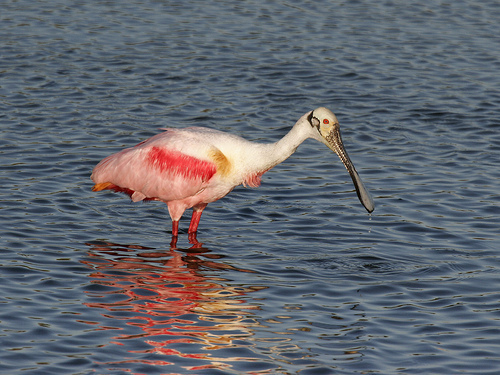

In [2]:
img_dir = 'images'
img_name = 'water-bird.jpg'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

In [3]:
def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.sub(mean).div(std)


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.do(tensor)
    
    def do(self, tensor):
        return normalize(tensor, self.mean, self.std)
    
    def undo(self, tensor):
        return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [4]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.interpolate(torch_img, size=(224, 224), mode='bilinear', align_corners=False) # (1, 3, 224, 224)
normed_torch_img = normalizer(torch_img)

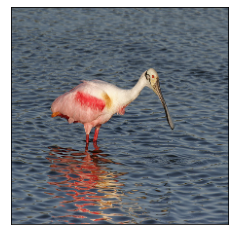

In [5]:
# Image check.

img = np.transpose(torch_img.cpu().numpy().squeeze(), (1, 2, 0)) # (224, 224, 3)
plt.imshow(img)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

In [6]:
current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')

saved_loc = os.path.join('./', current_time)
if os.path.exists(saved_loc):
    shutil.rmtree(saved_loc)
os.mkdir(saved_loc)

print("결과 저장 위치: ", saved_loc)

결과 저장 위치:  ./2021-05-10-18:01


Predicted label : 129, Probability : 1.00


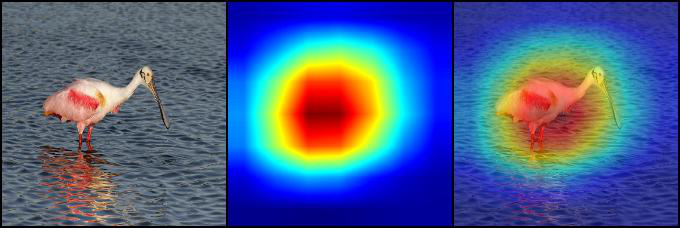

In [9]:
# final conv layer name 
finalconv_name = 'layer4'

# activations
feature_blobs = []

# gradients
backward_feature = []

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())
    

# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])
    

resnet18._modules.get(finalconv_name).register_forward_hook(hook_feature)
resnet18._modules.get(finalconv_name).register_backward_hook(backward_hook)


# get the softmax weight
params = list(resnet18.parameters())
weight_softmax = np.squeeze(params[-2].cpu().detach().numpy()) # [1000, 512]

# Prediction
logit = resnet18(normed_torch_img)
h_x = F.softmax(logit, dim=1).data.squeeze() # softmax 적용

probs, idx = h_x.sort(0, True)
print("Predicted label : %d, Probability : %.2f" % (idx[0].item(), probs[0].item()))


# ============================= #
# ==== Grad-CAM main lines ==== #
# ============================= #


score = logit[:, idx[0]].squeeze() # 예측값 y^c
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행
    
activations = torch.Tensor(feature_blobs[0]).to(device) # (1, 512, 7, 7), forward activations
gradients = backward_feature[0] # (1, 512, 7, 7), backward gradients
b, k, u, v = gradients.size()

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(224, 224), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 224, 224), min-max scaling
    
# grad_cam_map.squeeze() : (224, 224)
grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy 
grad_heatmap = torch.from_numpy(grad_heatmap).permute(2, 0, 1).float().div(255) # (3, 244, 244)
b, g, r = grad_heatmap.split(1)
grad_heatmap = torch.cat([r, g, b]) # (3, 244, 244), opencv's default format is BGR, so we need to change it as RGB format.

save_image(grad_heatmap, os.path.join(saved_loc, "Grad_CAM.jpg"))

grad_result = grad_heatmap + torch_img.cpu() # (1, 3, 244, 244)
grad_result = grad_result.div(grad_result.max()).squeeze() # (3, 244, 244)

save_image(grad_result, os.path.join(saved_loc, "result.jpg"))

image_list = []

image_list.append(torch.stack([torch_img.squeeze().cpu(), grad_heatmap, grad_result], 0)) # (3, 3, 244, 244)

images = make_grid(torch.cat(image_list, 0), nrow=3)

output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
output_name = img_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
PIL.Image.open(output_path)
